# Classifying Lung Cancer Using Tabular Dataset

By: Urban Halpern

Date: 12/5/2024

In [1]:
%%capture
!pip install -r requirements.txt

In [5]:
!cp /content/drive/MyDrive/lung_colon_image_set/image_features.csv /content

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
raw_dataset = pd.read_csv('/content/image_features.csv')

### Inspect Data

In [ ]:
raw_dataset.head()

,class,image_name,contrast,homogeneity,energy,correlation,lbp_bin_0,lbp_bin_1,lbp_bin_2,lbp_bin_3,...,lbp_bin_21,lbp_bin_22,lbp_bin_23,lbp_bin_24,lbp_bin_25,area,perimeter,eccentricity,solidity,extent
0,lung_scc,lungscc976.jpeg,16.156477,0.310437,0.032472,0.988117,0.034631,0.009396,0.012868,0.015962,...,0.018460,0.014565,0.009245,0.037294,0.205955,401369.0,25888.335049,0.242678,0.681096,0.680489
1,lung_scc,lungscc2341.jpeg,13.289249,0.370745,0.034267,0.995258,0.028547,0.008767,0.011502,0.013236,...,0.015381,0.012121,0.007804,0.033975,0.184482,502373.0,12711.938377,0.158283,0.851734,0.851734
2,lung_scc,lungscc680.jpeg,15.655545,0.322812,0.030507,0.991818,0.029783,0.008464,0.011607,0.014248,...,0.016885,0.012822,0.008457,0.034207,0.187578,306796.0,28395.622818,0.598942,0.555140,0.520148
3,lung_scc,lungscc2576.jpeg,13.195788,0.350813,0.027217,0.995098,0.019862,0.006058,0.008425,0.010929,...,0.011602,0.008521,0.005303,0.023636,0.132945,1.0,0.000000,0.000000,1.000000,1.000000
4,lung_scc,lungscc3243.jpeg,7.818707,0.432422,0.037133,0.996295,0.026104,0.008594,0.011215,0.013494,...,0.015406,0.011536,0.007473,0.034064,0.181695,465538.0,16083.640359,0.295890,0.791194,0.789283


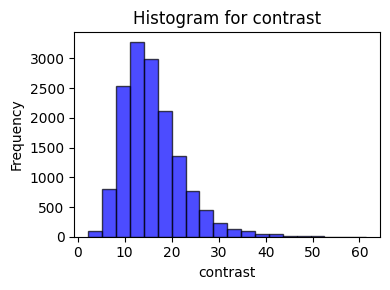

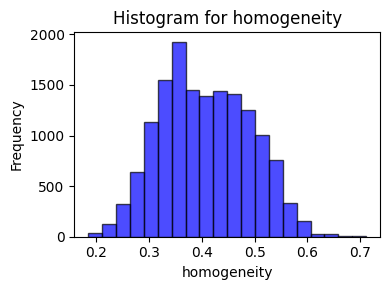

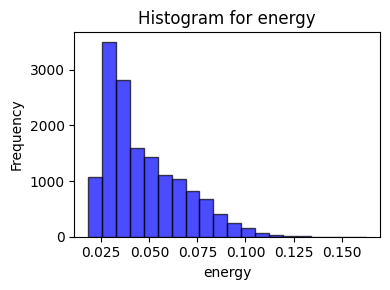

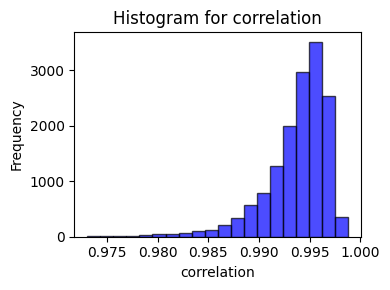

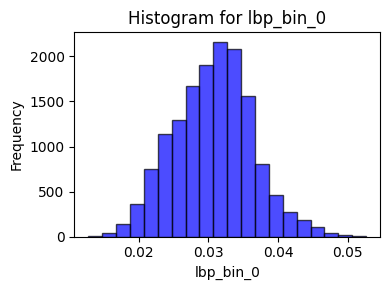

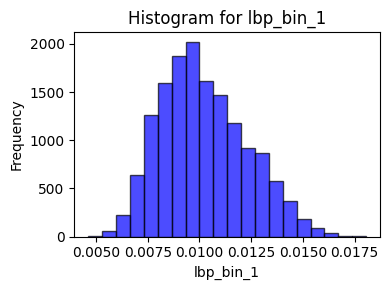

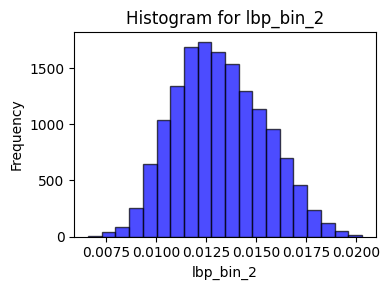

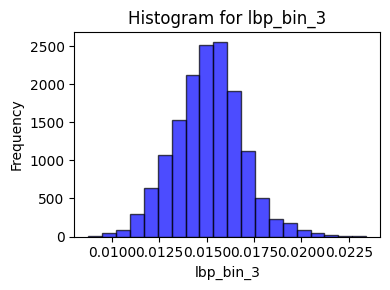

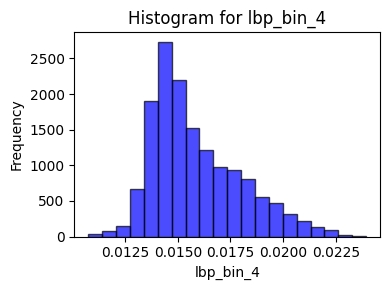

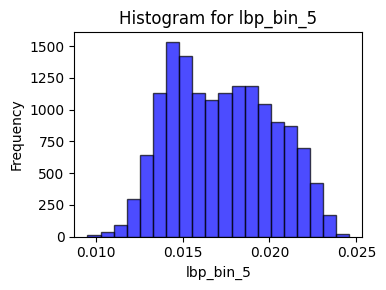

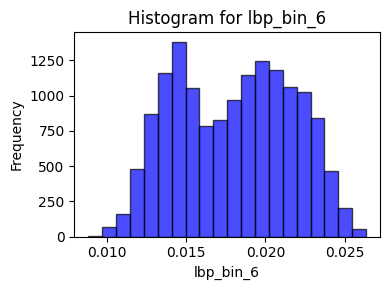

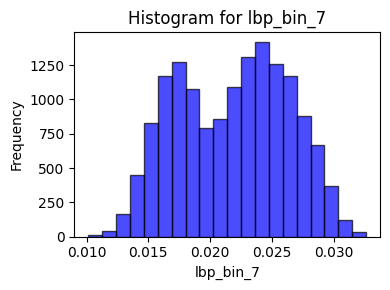

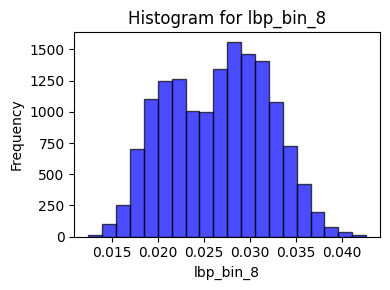

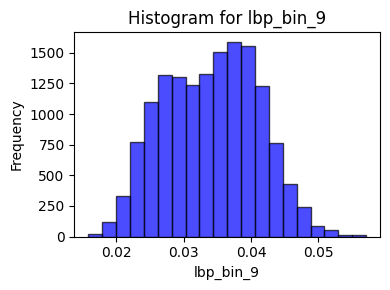

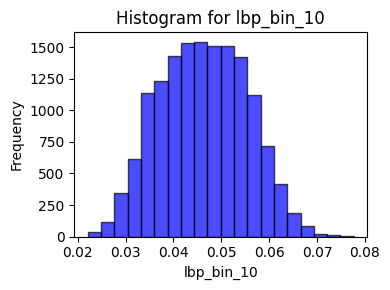

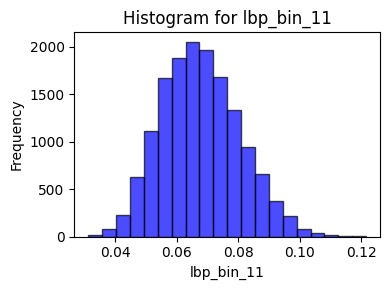

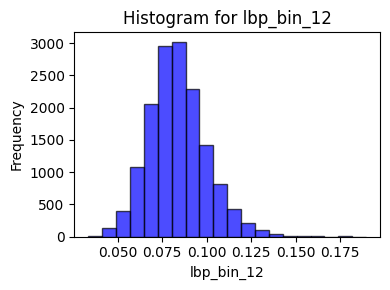

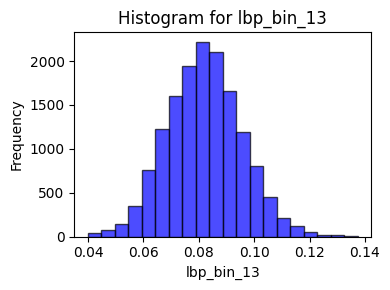

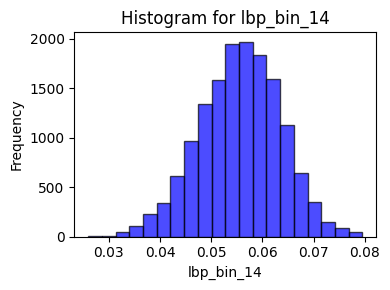

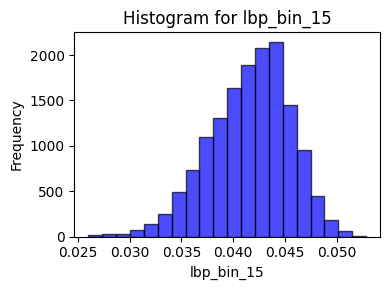

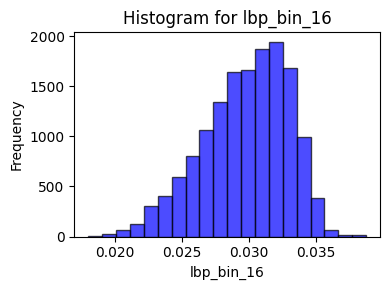

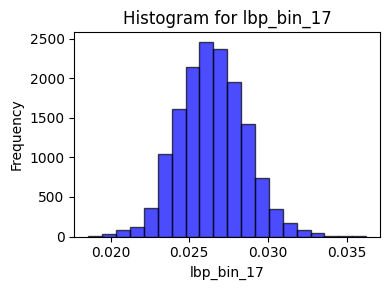

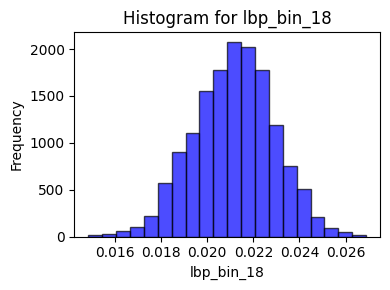

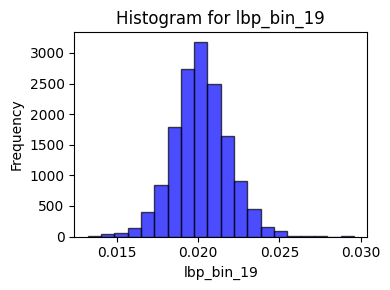

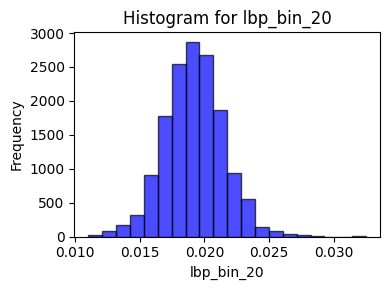

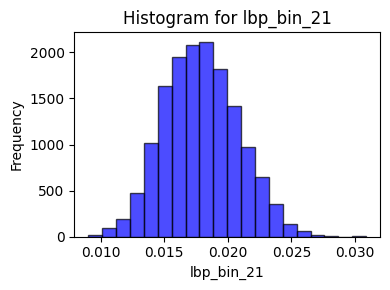

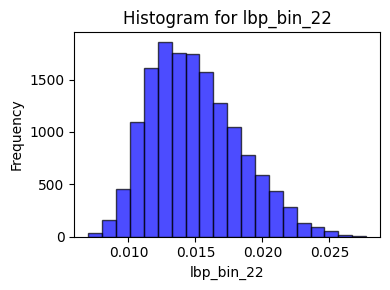

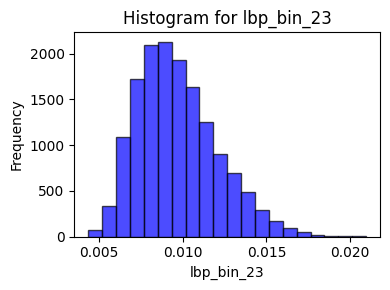

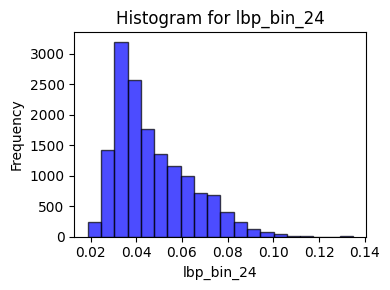

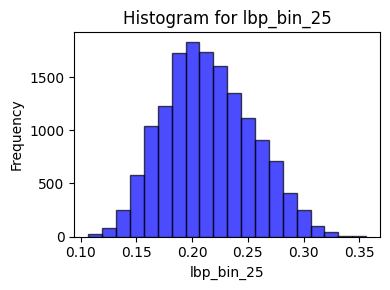

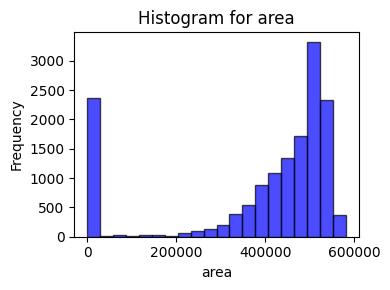

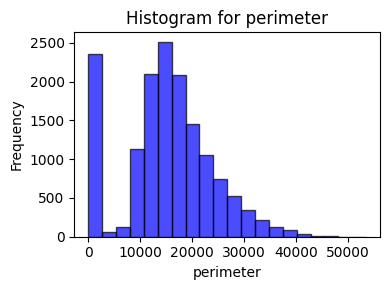

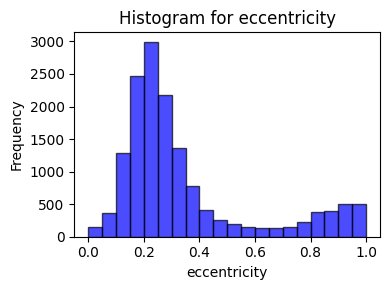

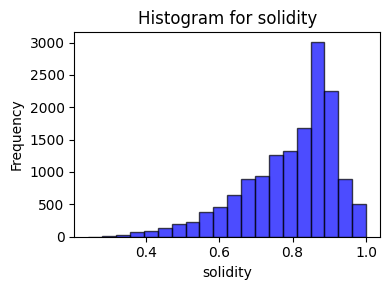

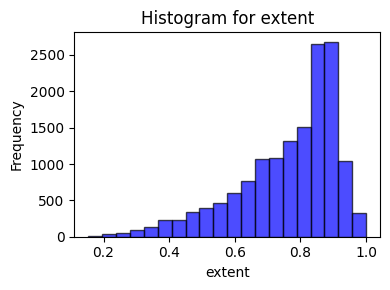

In [ ]:
for column in raw_dataset.iloc[:, 2:37]:
    plt.figure(figsize=(4, 3))
    plt.hist(raw_dataset[column], bins=20, alpha=0.7, color='blue', edgecolor='black')  # Customize bins and colors as needed
    plt.title(f"Histogram for {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

For the features that appear skewed or have large magenitudes, we will apply log transformations to normalize the data

In [7]:
cleaned_df = raw_dataset.dropna(axis=0)

In [8]:
cleaned_df.shape

(15000, 37)

In [9]:
def normalize(column):
    upper = column.max()
    lower = column.min()
    y = (column - lower)/(upper-lower)
    return y

In [10]:
cleaned_df["area"] = np.sqrt(cleaned_df["area"] + 1)
cleaned_df["perimeter"] = np.sqrt(cleaned_df["perimeter"])
cleaned_df["contrast"] = np.log(cleaned_df["contrast"] + 1)

cleaned_df["energy"] = np.log(cleaned_df["energy"])
cleaned_df["energy"] = normalize(cleaned_df["energy"])

cleaned_df["correlation"] = np.log(cleaned_df["correlation"] + 1)
cleaned_df["correlation"] = normalize(cleaned_df["correlation"])

cleaned_df["lbp_bin_23"] = np.log(cleaned_df["lbp_bin_23"] + 1)
cleaned_df["lbp_bin_23"] = normalize(cleaned_df["lbp_bin_23"])

cleaned_df["lbp_bin_24"] = np.log(cleaned_df["lbp_bin_24"] + 1)
cleaned_df["lbp_bin_24"] = normalize(cleaned_df["lbp_bin_24"])

cleaned_df.head(2)

,class,image_name,contrast,homogeneity,energy,correlation,lbp_bin_0,lbp_bin_1,lbp_bin_2,lbp_bin_3,...,lbp_bin_21,lbp_bin_22,lbp_bin_23,lbp_bin_24,lbp_bin_25,area,perimeter,eccentricity,solidity,extent
0,lung_scc,lungscc976.jpeg,2.842376,0.310437,0.263174,0.587195,0.034631,0.009396,0.012868,0.015962,...,0.018460,0.014565,0.295269,0.167301,0.205955,633.537686,160.898524,0.242678,0.681096,0.680489
1,lung_scc,lungscc2341.jpeg,2.659507,0.370745,0.287763,0.864409,0.028547,0.008767,0.011502,0.013236,...,0.015381,0.012121,0.207877,0.137636,0.184482,708.783465,112.747232,0.158283,0.851734,0.851734


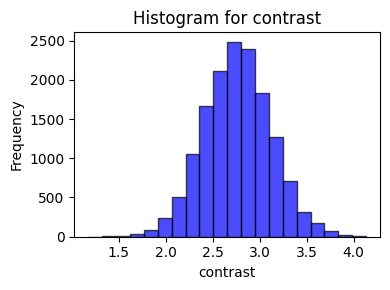

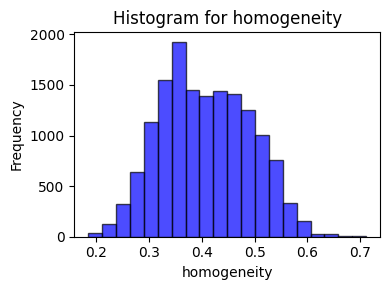

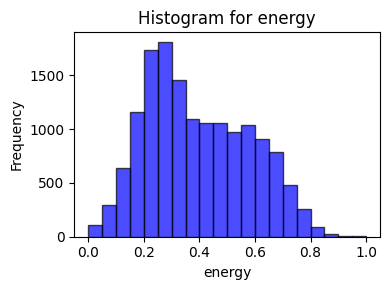

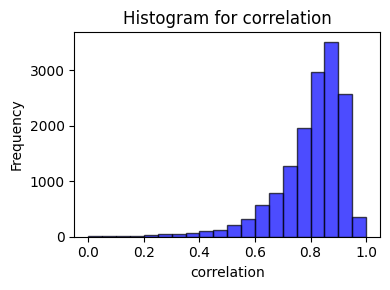

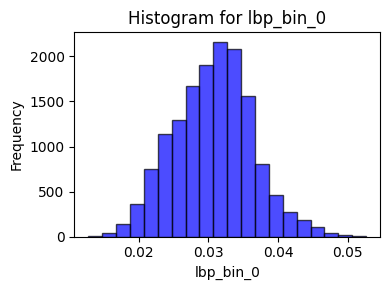

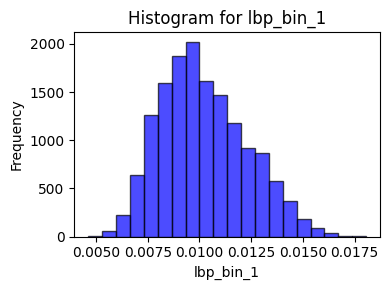

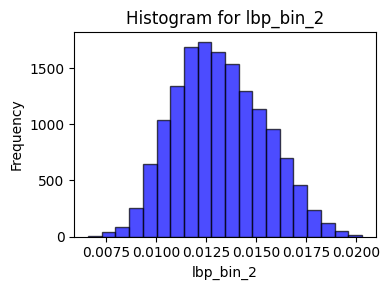

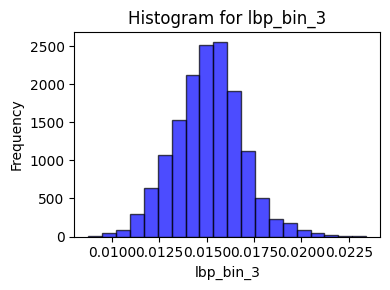

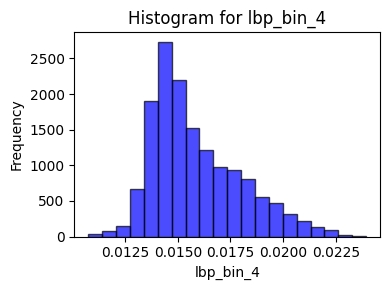

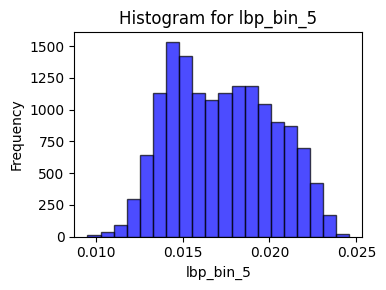

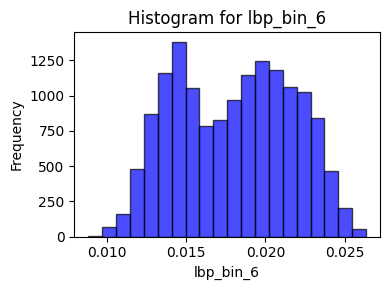

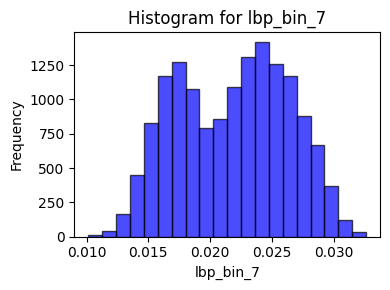

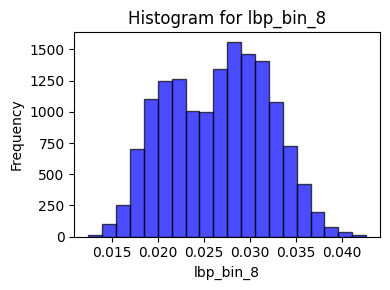

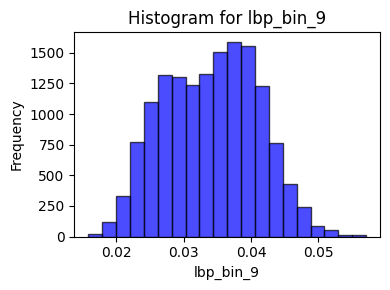

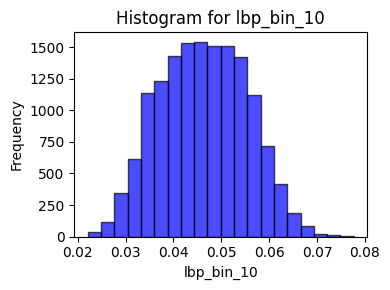

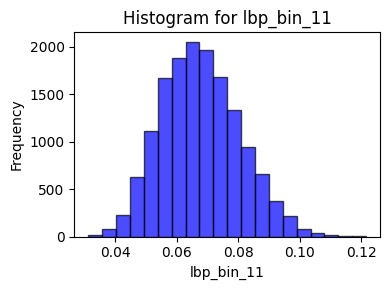

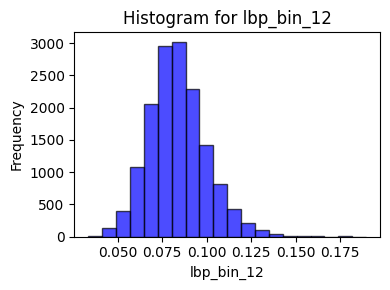

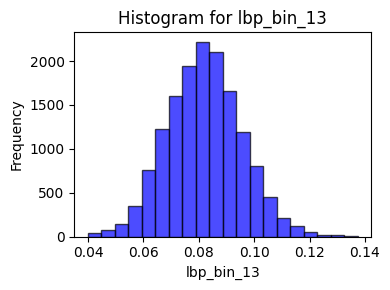

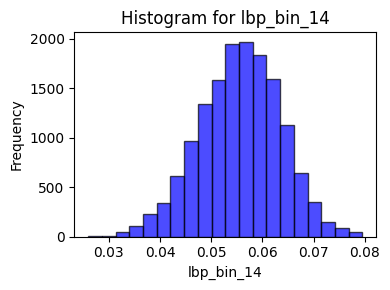

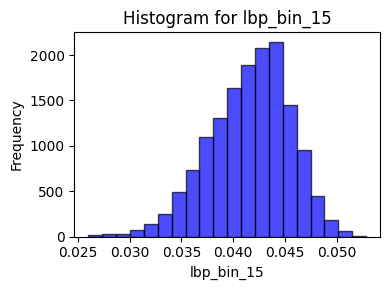

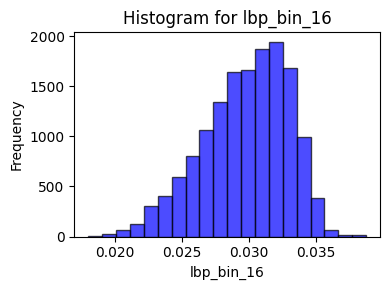

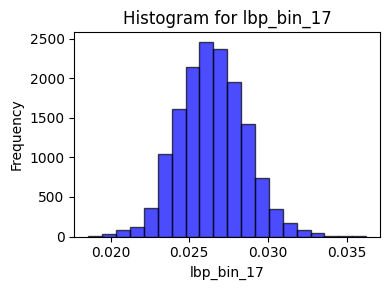

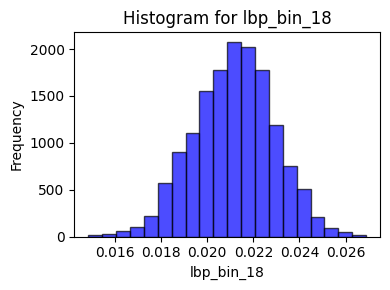

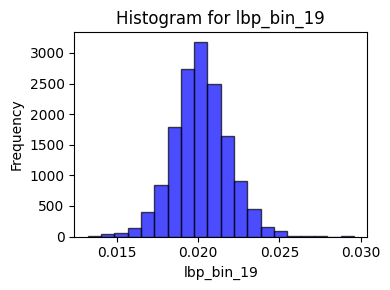

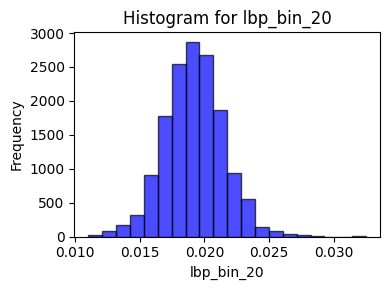

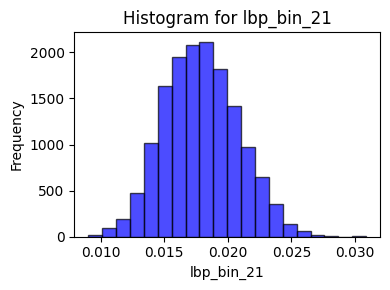

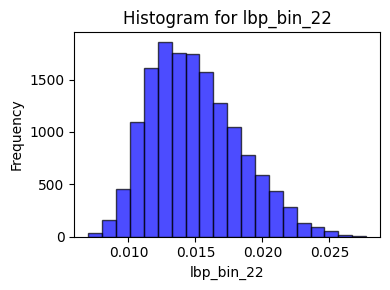

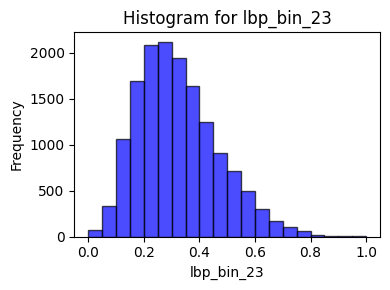

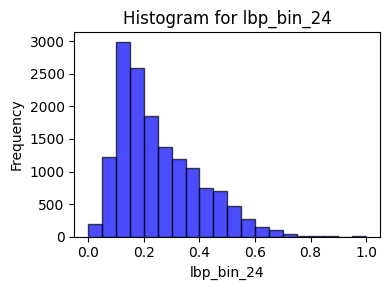

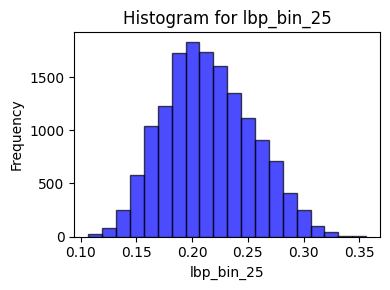

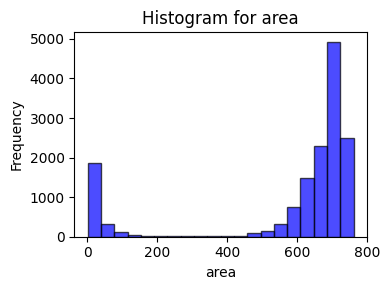

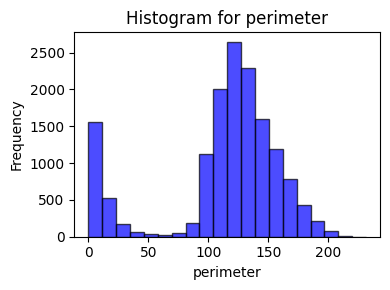

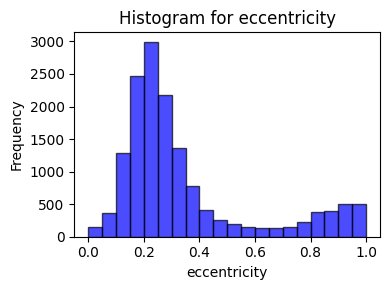

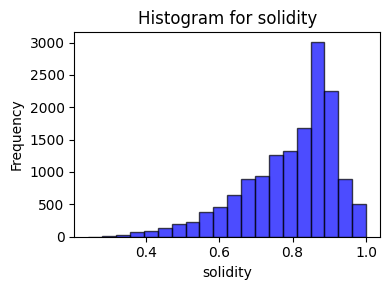

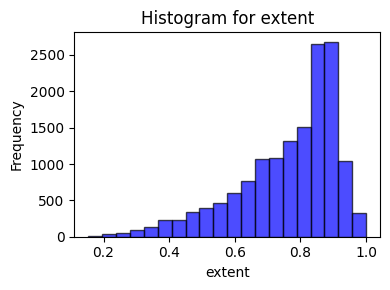

In [ ]:
for column in cleaned_df.iloc[:, 2:37]:
    plt.figure(figsize=(4, 3))
    plt.hist(cleaned_df[column], bins=20, alpha=0.7, color='blue', edgecolor='black')  # Customize bins and colors as needed
    plt.title(f"Histogram for {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

## Building a Tabular Neural Network Using Pytorch Tabnet

### Splitting Dataset

In [11]:
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetClassifier
import torch.nn as nn
import torch.optim as optim

In [12]:
X = cleaned_df.drop(columns=['class', 'image_name'])
y = cleaned_df['class']

# We make a first split of 20% train and 80% test with equal classes
X_train_valid, X_test, y_train_valid, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# A second split of 25% validation and 75% train gives
# a 60/20/20 for train/validation/test
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_valid, y_train_valid, test_size=0.25, random_state=42, stratify=y_train_valid
)

print("Train set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_valid.shape, y_valid.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (9000, 35) (9000,)
Validation set shape: (3000, 35) (3000,)
Test set shape: (3000, 35) (3000,)


In [11]:
y_train.value_counts()

,count
class,
lung_n,3000
lung_scc,3000
lung_aca,3000


In [17]:
y_test.value_counts()

,count
class,
lung_n,1000
lung_aca,1000
lung_scc,1000


In [21]:
y_valid.value_counts()

,count
class,
lung_n,1000
lung_scc,1000
lung_aca,1000


In [ ]:
X.shape

(15000, 35)

### Training Tabnet Classiifer

In [28]:
from pytorch_tabnet.callbacks import Callback

# Saves evaluation metrics after each training iteration
class LossHistory(Callback):
    def __init__(self):
        self.train_losses = []
        self.valid_losses = []

    def on_epoch_end(self, epoch, logs=None):
        self.train_losses.append(logs['loss'])
        self.valid_losses.append(logs['validation_accuracy'])

In [52]:
def log_training(log_df, iteration_id, learning_rate, weight_decay, optimizer_name,
                  num_epochs, early_stopping_patience, stopped_epoch, training_loss_arr,
                 val_accuracy, batch_size, log_filename="tabular_training_log.csv"):
    """
    Args:
      log_df: dataframe template that defines csv output structure
      hyperparameters: (iteration_id - batch_size) hyperparameters to keep track of
      evaluation metrics: (stopped_epoch- val_accuracy) metrics to track
      log_filename: name of csv file to write to

    Description:
      After each training iteration, this function will be called to create a history
      of models created defined by their hyperparameters and evaluated on validation accuracy
    """

    new_log_data = {
        "iteration_id": iteration_id,
        "learning_rate": learning_rate,
        "weight_decay": weight_decay,
        "optimizer": optimizer_name,
        "num_epochs": num_epochs,
        "early_stopping_patience": early_stopping_patience,
        "stopped_epoch": stopped_epoch,
        "training_loss": training_loss_arr,  # Full training loss history
        "validation_accuracy": val_accuracy,  # Final validation accuracy
        "batch_size": batch_size
    }

    # append new data to DataFrame
    log_df = pd.concat([log_df, pd.DataFrame([new_log_data])], ignore_index=True)

    # append to a CSV file each time training is completed
    if os.path.exists(log_filename):
        log_df.to_csv(log_filename, index=False, mode='a', header=False)
    else:
        log_df.to_csv(log_filename, index=False)

# Initialize logging dataframe
log_df = pd.DataFrame(columns=[
    "iteration_id", "learning_rate", "weight_decay","optimizer",
    "num_epochs", "early_stopping_patience", "stopped_epoch",
    "training_loss", "validation_accuracy", "batch_size"
])

In [31]:
import torch
import random
import os

In [53]:
param_grid = {
    'lr': [0.005, 0.01, 0.02],
    'weight_decay': [0.001, 0.005, 0.01],
    'num_epochs': [75, 100],
    'batch_size': [32, 100],
    'n_d': [7, 8, 9],  # Decision width (around default of 8)
    'n_a': [7, 8, 9],  # Attention width (around default of 8)
    'n_steps': [2, 3, 4],  # Number of steps (around default of 3)
    'gamma': [1.2, 1.3, 1.5],  # Regularization for feature reuse (around default of 1.3)
    'lambda_sparse': [0.00005, 0.0001, 0.0002]  # Sparsity regularization (around default of 0.0001)
}

# patience is fixed for all iterations
patience = 5

# Number of trianing iterations
num_samples = 30

# randomly sample hyperparameters and train models
for i in range(num_samples):

    loss_history = LossHistory()

    iteration_id = i + 1

    # Selection of hyperparameters
    lr = random.choice(param_grid['lr'])
    weight_decay = random.choice(param_grid['weight_decay'])
    num_epochs = random.choice(param_grid['num_epochs'])
    batch_size = random.choice(param_grid['batch_size'])
    n_d = random.choice(param_grid['n_d'])
    n_a = random.choice(param_grid['n_a'])
    n_steps = random.choice(param_grid['n_steps'])
    gamma = random.choice(param_grid['gamma'])
    lambda_sparse = random.choice(param_grid['lambda_sparse'])

    # Log the chosen hyperparameters
    print(f"Training iteration {i + 1} with hyperparameters:")
    print(f"  lr={lr}, weight_decay={weight_decay}, num_epochs={num_epochs}, "
          f"batch_size={batch_size}, n_d={n_d}, n_a={n_a}, n_steps={n_steps}, "
          f"gamma={gamma}, lambda_sparse={lambda_sparse}\n")

    # Initialize the TabNetClassifier with chosen hyperparameters
    clf = TabNetClassifier(
        device_name='cuda' if torch.cuda.is_available() else 'cpu',
        optimizer_fn=optim.Adam,
        optimizer_params={'lr': lr, 'weight_decay': weight_decay},
        n_d=n_d,
        n_a=n_a,
        n_steps=n_steps,
        gamma=gamma,
        lambda_sparse=lambda_sparse
    )

    clf.preds_mapper = {0: "lung_aca", 1: "lung_scc", 2: "lung_n"}

    # Train the model
    clf.fit(
        X_train.values, y_train.values,
        eval_set=[(X_valid.values, y_valid.values)],
        eval_name=['validation'],
        eval_metric=['accuracy'],
        max_epochs=num_epochs,
        patience=patience,
        batch_size=batch_size,
        num_workers = 2,
        callbacks=[loss_history]
    )

    # Log Model
    training_loss_arr = loss_history.train_losses
    validation_accuracy = loss_history.valid_losses[-1]
    stopped_epoch = len(loss_history.valid_losses) - 1

    log_training(log_df, iteration_id, lr, weight_decay, "Adam", num_epochs,
            patience, stopped_epoch, training_loss_arr, validation_accuracy, batch_size)

    # Save the model
    model_save_path = f'./Tabular_Models/iteration_{iteration_id}_tabnet.pth'
    clf.save_model(model_save_path)
    print(f"Model for iteration {iteration_id} saved at: {model_save_path}\n")

# Training is complete
print("Random search completed.")

Training iteration 1 with hyperparameters:
  lr=0.005, weight_decay=0.01, num_epochs=75, batch_size=32, n_d=7, n_a=7, n_steps=2, gamma=1.3, lambda_sparse=0.0001



/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.60386 | validation_accuracy: 0.33333 |  0:00:06s
epoch 1  | loss: 0.35675 | validation_accuracy: 0.42733 |  0:00:12s
epoch 2  | loss: 0.32517 | validation_accuracy: 0.68367 |  0:00:18s
epoch 3  | loss: 0.33417 | validation_accuracy: 0.79233 |  0:00:24s
epoch 4  | loss: 0.3313  | validation_accuracy: 0.88833 |  0:00:30s
epoch 5  | loss: 0.31298 | validation_accuracy: 0.888   |  0:00:37s
epoch 6  | loss: 0.31285 | validation_accuracy: 0.89767 |  0:00:43s
epoch 7  | loss: 0.29677 | validation_accuracy: 0.92333 |  0:00:49s
epoch 8  | loss: 0.29606 | validation_accuracy: 0.68467 |  0:00:55s
epoch 9  | loss: 0.31682 | validation_accuracy: 0.92633 |  0:01:02s
epoch 10 | loss: 0.30884 | validation_accuracy: 0.90033 |  0:01:08s
epoch 11 | loss: 0.30807 | validation_accuracy: 0.879   |  0:01:14s
epoch 12 | loss: 0.30343 | validation_accuracy: 0.891   |  0:01:22s
epoch 13 | loss: 0.31029 | validation_accuracy: 0.88333 |  0:01:30s
epoch 14 | loss: 0.31021 | validation_accuracy: 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at ./Tabular_Models/iteration_1_tabnet.pth.zip
Model for iteration 1 saved at: ./Tabular_Models/iteration_1_tabnet.pth

Training iteration 2 with hyperparameters:
  lr=0.01, weight_decay=0.01, num_epochs=75, batch_size=100, n_d=8, n_a=9, n_steps=3, gamma=1.5, lambda_sparse=0.0001



<ipython-input-52-3c51ecd38471>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([new_log_data])], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.85375 | validation_accuracy: 0.33333 |  0:00:04s
epoch 1  | loss: 0.35744 | validation_accuracy: 0.33333 |  0:00:09s
epoch 2  | loss: 0.31079 | validation_accuracy: 0.33333 |  0:00:11s
epoch 3  | loss: 0.28494 | validation_accuracy: 0.33333 |  0:00:15s
epoch 4  | loss: 0.28745 | validation_accuracy: 0.33367 |  0:00:19s
epoch 5  | loss: 0.26812 | validation_accuracy: 0.338   |  0:00:23s
epoch 6  | loss: 0.26504 | validation_accuracy: 0.46467 |  0:00:27s
epoch 7  | loss: 0.26387 | validation_accuracy: 0.714   |  0:00:29s
epoch 8  | loss: 0.24968 | validation_accuracy: 0.89833 |  0:00:32s
epoch 9  | loss: 0.2644  | validation_accuracy: 0.809   |  0:00:36s
epoch 10 | loss: 0.26168 | validation_accuracy: 0.80033 |  0:00:38s
epoch 11 | loss: 0.26846 | validation_accuracy: 0.89167 |  0:00:41s
epoch 12 | loss: 0.25151 | validation_accuracy: 0.757   |  0:00:43s
epoch 13 | loss: 0.26158 | validation_accuracy: 0.86067 |  0:00:48s

Early stopping occurred at epoch 13 with best_e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at ./Tabular_Models/iteration_2_tabnet.pth.zip
Model for iteration 2 saved at: ./Tabular_Models/iteration_2_tabnet.pth

Training iteration 3 with hyperparameters:
  lr=0.01, weight_decay=0.001, num_epochs=75, batch_size=100, n_d=8, n_a=8, n_steps=2, gamma=1.5, lambda_sparse=5e-05



<ipython-input-52-3c51ecd38471>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([new_log_data])], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72866 | validation_accuracy: 0.33333 |  0:00:02s
epoch 1  | loss: 0.31277 | validation_accuracy: 0.33333 |  0:00:04s
epoch 2  | loss: 0.27645 | validation_accuracy: 0.33333 |  0:00:06s
epoch 3  | loss: 0.25166 | validation_accuracy: 0.338   |  0:00:08s
epoch 4  | loss: 0.23246 | validation_accuracy: 0.35533 |  0:00:11s
epoch 5  | loss: 0.22156 | validation_accuracy: 0.437   |  0:00:13s
epoch 6  | loss: 0.21227 | validation_accuracy: 0.55    |  0:00:15s
epoch 7  | loss: 0.20679 | validation_accuracy: 0.601   |  0:00:17s
epoch 8  | loss: 0.19788 | validation_accuracy: 0.75833 |  0:00:20s
epoch 9  | loss: 0.20338 | validation_accuracy: 0.79367 |  0:00:22s
epoch 10 | loss: 0.20197 | validation_accuracy: 0.79167 |  0:00:25s
epoch 11 | loss: 0.18863 | validation_accuracy: 0.85867 |  0:00:28s
epoch 12 | loss: 0.18679 | validation_accuracy: 0.942   |  0:00:30s
epoch 13 | loss: 0.19191 | validation_accuracy: 0.94467 |  0:00:32s
epoch 14 | loss: 0.17959 | validation_accuracy: 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at ./Tabular_Models/iteration_3_tabnet.pth.zip
Model for iteration 3 saved at: ./Tabular_Models/iteration_3_tabnet.pth

Training iteration 4 with hyperparameters:
  lr=0.01, weight_decay=0.001, num_epochs=75, batch_size=32, n_d=7, n_a=9, n_steps=4, gamma=1.2, lambda_sparse=5e-05



<ipython-input-52-3c51ecd38471>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([new_log_data])], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.58849 | validation_accuracy: 0.33333 |  0:00:11s
epoch 1  | loss: 0.38849 | validation_accuracy: 0.36133 |  0:00:24s
epoch 2  | loss: 0.35476 | validation_accuracy: 0.55167 |  0:00:38s
epoch 3  | loss: 0.33055 | validation_accuracy: 0.91133 |  0:00:53s
epoch 4  | loss: 0.29005 | validation_accuracy: 0.88967 |  0:01:07s
epoch 5  | loss: 0.28444 | validation_accuracy: 0.91667 |  0:01:17s
epoch 6  | loss: 0.27936 | validation_accuracy: 0.917   |  0:01:29s
epoch 7  | loss: 0.28957 | validation_accuracy: 0.90767 |  0:01:42s
epoch 8  | loss: 0.27441 | validation_accuracy: 0.91533 |  0:01:54s
epoch 9  | loss: 0.26892 | validation_accuracy: 0.91767 |  0:02:07s
epoch 10 | loss: 0.26283 | validation_accuracy: 0.899   |  0:02:22s
epoch 11 | loss: 0.26572 | validation_accuracy: 0.76567 |  0:02:32s
epoch 12 | loss: 0.2554  | validation_accuracy: 0.926   |  0:02:43s
epoch 13 | loss: 0.2565  | validation_accuracy: 0.92633 |  0:02:54s
epoch 14 | loss: 0.24021 | validation_accuracy: 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at ./Tabular_Models/iteration_4_tabnet.pth.zip
Model for iteration 4 saved at: ./Tabular_Models/iteration_4_tabnet.pth

Training iteration 5 with hyperparameters:
  lr=0.01, weight_decay=0.001, num_epochs=100, batch_size=100, n_d=8, n_a=7, n_steps=4, gamma=1.2, lambda_sparse=0.0002



<ipython-input-52-3c51ecd38471>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([new_log_data])], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.74401 | validation_accuracy: 0.33333 |  0:00:04s
epoch 1  | loss: 0.37928 | validation_accuracy: 0.33333 |  0:00:10s
epoch 2  | loss: 0.34102 | validation_accuracy: 0.33333 |  0:00:15s
epoch 3  | loss: 0.29173 | validation_accuracy: 0.33333 |  0:00:18s
epoch 4  | loss: 0.26988 | validation_accuracy: 0.353   |  0:00:23s
epoch 5  | loss: 0.24752 | validation_accuracy: 0.48033 |  0:00:27s
epoch 6  | loss: 0.24819 | validation_accuracy: 0.50833 |  0:00:32s
epoch 7  | loss: 0.22914 | validation_accuracy: 0.50667 |  0:00:37s
epoch 8  | loss: 0.2247  | validation_accuracy: 0.62567 |  0:00:41s
epoch 9  | loss: 0.21551 | validation_accuracy: 0.683   |  0:00:45s
epoch 10 | loss: 0.2097  | validation_accuracy: 0.82867 |  0:00:50s
epoch 11 | loss: 0.19092 | validation_accuracy: 0.908   |  0:00:55s
epoch 12 | loss: 0.19435 | validation_accuracy: 0.91367 |  0:01:00s
epoch 13 | loss: 0.1894  | validation_accuracy: 0.934   |  0:01:06s
epoch 14 | loss: 0.19267 | validation_accuracy: 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at ./Tabular_Models/iteration_5_tabnet.pth.zip
Model for iteration 5 saved at: ./Tabular_Models/iteration_5_tabnet.pth

Training iteration 6 with hyperparameters:
  lr=0.005, weight_decay=0.001, num_epochs=100, batch_size=100, n_d=7, n_a=7, n_steps=4, gamma=1.3, lambda_sparse=0.0001



<ipython-input-52-3c51ecd38471>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([new_log_data])], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.01511 | validation_accuracy: 0.42767 |  0:00:05s
epoch 1  | loss: 0.52873 | validation_accuracy: 0.33333 |  0:00:09s
epoch 2  | loss: 0.41785 | validation_accuracy: 0.33333 |  0:00:12s
epoch 3  | loss: 0.3793  | validation_accuracy: 0.344   |  0:00:16s
epoch 4  | loss: 0.34275 | validation_accuracy: 0.38567 |  0:00:20s
epoch 5  | loss: 0.30214 | validation_accuracy: 0.36867 |  0:00:23s

Early stopping occurred at epoch 5 with best_epoch = 0 and best_validation_accuracy = 0.42767


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at ./Tabular_Models/iteration_6_tabnet.pth.zip
Model for iteration 6 saved at: ./Tabular_Models/iteration_6_tabnet.pth

Training iteration 7 with hyperparameters:
  lr=0.02, weight_decay=0.005, num_epochs=100, batch_size=100, n_d=7, n_a=9, n_steps=4, gamma=1.5, lambda_sparse=0.0001



<ipython-input-52-3c51ecd38471>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([new_log_data])], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.63896 | validation_accuracy: 0.33333 |  0:00:03s
epoch 1  | loss: 0.35648 | validation_accuracy: 0.33333 |  0:00:08s
epoch 2  | loss: 0.31796 | validation_accuracy: 0.33333 |  0:00:13s
epoch 3  | loss: 0.30103 | validation_accuracy: 0.33333 |  0:00:17s
epoch 4  | loss: 0.27969 | validation_accuracy: 0.488   |  0:00:23s
epoch 5  | loss: 0.2773  | validation_accuracy: 0.41967 |  0:00:27s
epoch 6  | loss: 0.26704 | validation_accuracy: 0.64933 |  0:00:31s
epoch 7  | loss: 0.28089 | validation_accuracy: 0.62633 |  0:00:34s
epoch 8  | loss: 0.26911 | validation_accuracy: 0.816   |  0:00:38s
epoch 9  | loss: 0.26503 | validation_accuracy: 0.74633 |  0:00:41s
epoch 10 | loss: 0.26753 | validation_accuracy: 0.911   |  0:00:45s
epoch 11 | loss: 0.25716 | validation_accuracy: 0.87933 |  0:00:48s
epoch 12 | loss: 0.26182 | validation_accuracy: 0.811   |  0:00:52s
epoch 13 | loss: 0.25127 | validation_accuracy: 0.89    |  0:00:55s
epoch 14 | loss: 0.26111 | validation_accuracy: 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at ./Tabular_Models/iteration_7_tabnet.pth.zip
Model for iteration 7 saved at: ./Tabular_Models/iteration_7_tabnet.pth

Training iteration 8 with hyperparameters:
  lr=0.005, weight_decay=0.005, num_epochs=100, batch_size=100, n_d=9, n_a=8, n_steps=3, gamma=1.5, lambda_sparse=0.0001



<ipython-input-52-3c51ecd38471>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([new_log_data])], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.92188 | validation_accuracy: 0.334   |  0:00:02s
epoch 1  | loss: 0.46979 | validation_accuracy: 0.33333 |  0:00:05s
epoch 2  | loss: 0.37077 | validation_accuracy: 0.33867 |  0:00:08s
epoch 3  | loss: 0.30372 | validation_accuracy: 0.34233 |  0:00:10s
epoch 4  | loss: 0.28433 | validation_accuracy: 0.362   |  0:00:14s
epoch 5  | loss: 0.27495 | validation_accuracy: 0.39333 |  0:00:17s
epoch 6  | loss: 0.25144 | validation_accuracy: 0.54967 |  0:00:19s
epoch 7  | loss: 0.24451 | validation_accuracy: 0.68867 |  0:00:22s
epoch 8  | loss: 0.23717 | validation_accuracy: 0.77667 |  0:00:25s
epoch 9  | loss: 0.23407 | validation_accuracy: 0.79133 |  0:00:29s
epoch 10 | loss: 0.22572 | validation_accuracy: 0.89067 |  0:00:31s
epoch 11 | loss: 0.21904 | validation_accuracy: 0.89267 |  0:00:34s
epoch 12 | loss: 0.21456 | validation_accuracy: 0.89967 |  0:00:37s
epoch 13 | loss: 0.20528 | validation_accuracy: 0.91867 |  0:00:40s
epoch 14 | loss: 0.20383 | validation_accuracy: 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at ./Tabular_Models/iteration_8_tabnet.pth.zip
Model for iteration 8 saved at: ./Tabular_Models/iteration_8_tabnet.pth

Training iteration 9 with hyperparameters:
  lr=0.005, weight_decay=0.01, num_epochs=100, batch_size=32, n_d=8, n_a=8, n_steps=2, gamma=1.2, lambda_sparse=5e-05



<ipython-input-52-3c51ecd38471>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([new_log_data])], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72236 | validation_accuracy: 0.33833 |  0:00:06s
epoch 1  | loss: 0.34655 | validation_accuracy: 0.59133 |  0:00:13s
epoch 2  | loss: 0.32169 | validation_accuracy: 0.73033 |  0:00:19s
epoch 3  | loss: 0.31093 | validation_accuracy: 0.88133 |  0:00:25s
epoch 4  | loss: 0.30056 | validation_accuracy: 0.861   |  0:00:32s
epoch 5  | loss: 0.31058 | validation_accuracy: 0.83533 |  0:00:38s
epoch 6  | loss: 0.31038 | validation_accuracy: 0.90833 |  0:00:45s
epoch 7  | loss: 0.31206 | validation_accuracy: 0.90667 |  0:00:51s
epoch 8  | loss: 0.29318 | validation_accuracy: 0.88833 |  0:00:58s
epoch 9  | loss: 0.31142 | validation_accuracy: 0.92767 |  0:01:04s
epoch 10 | loss: 0.31046 | validation_accuracy: 0.92533 |  0:01:11s
epoch 11 | loss: 0.31548 | validation_accuracy: 0.84933 |  0:01:17s
epoch 12 | loss: 0.31087 | validation_accuracy: 0.85833 |  0:01:24s
epoch 13 | loss: 0.31508 | validation_accuracy: 0.84867 |  0:01:30s
epoch 14 | loss: 0.31435 | validation_accuracy: 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at ./Tabular_Models/iteration_9_tabnet.pth.zip
Model for iteration 9 saved at: ./Tabular_Models/iteration_9_tabnet.pth

Training iteration 10 with hyperparameters:
  lr=0.005, weight_decay=0.001, num_epochs=100, batch_size=32, n_d=7, n_a=7, n_steps=4, gamma=1.3, lambda_sparse=0.0001



<ipython-input-52-3c51ecd38471>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([new_log_data])], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.79183 | validation_accuracy: 0.33933 |  0:00:10s
epoch 1  | loss: 0.42537 | validation_accuracy: 0.40067 |  0:00:19s
epoch 2  | loss: 0.37549 | validation_accuracy: 0.64467 |  0:00:29s
epoch 3  | loss: 0.31417 | validation_accuracy: 0.857   |  0:00:39s
epoch 4  | loss: 0.2879  | validation_accuracy: 0.92333 |  0:00:48s
epoch 5  | loss: 0.2781  | validation_accuracy: 0.91    |  0:00:58s
epoch 6  | loss: 0.25671 | validation_accuracy: 0.91967 |  0:01:08s
epoch 7  | loss: 0.2543  | validation_accuracy: 0.92667 |  0:01:20s
epoch 8  | loss: 0.24473 | validation_accuracy: 0.93133 |  0:01:28s
epoch 9  | loss: 0.25219 | validation_accuracy: 0.933   |  0:01:38s
epoch 10 | loss: 0.24409 | validation_accuracy: 0.91533 |  0:01:48s
epoch 11 | loss: 0.22191 | validation_accuracy: 0.91267 |  0:01:57s
epoch 12 | loss: 0.23772 | validation_accuracy: 0.91733 |  0:02:07s
epoch 13 | loss: 0.22441 | validation_accuracy: 0.93133 |  0:02:17s
epoch 14 | loss: 0.22295 | validation_accuracy: 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at ./Tabular_Models/iteration_10_tabnet.pth.zip
Model for iteration 10 saved at: ./Tabular_Models/iteration_10_tabnet.pth

Training iteration 11 with hyperparameters:
  lr=0.005, weight_decay=0.005, num_epochs=100, batch_size=32, n_d=9, n_a=9, n_steps=4, gamma=1.2, lambda_sparse=0.0001



<ipython-input-52-3c51ecd38471>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([new_log_data])], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.68159 | validation_accuracy: 0.33333 |  0:00:09s
epoch 1  | loss: 0.37452 | validation_accuracy: 0.46367 |  0:00:18s
epoch 2  | loss: 0.33628 | validation_accuracy: 0.734   |  0:00:29s
epoch 3  | loss: 0.29766 | validation_accuracy: 0.84167 |  0:00:39s
epoch 4  | loss: 0.2923  | validation_accuracy: 0.875   |  0:00:48s
epoch 5  | loss: 0.28204 | validation_accuracy: 0.91067 |  0:00:58s
epoch 6  | loss: 0.27586 | validation_accuracy: 0.92167 |  0:01:08s
epoch 7  | loss: 0.27118 | validation_accuracy: 0.921   |  0:01:17s
epoch 8  | loss: 0.276   | validation_accuracy: 0.93033 |  0:01:28s
epoch 9  | loss: 0.26849 | validation_accuracy: 0.89    |  0:01:38s
epoch 10 | loss: 0.27424 | validation_accuracy: 0.898   |  0:01:47s
epoch 11 | loss: 0.27544 | validation_accuracy: 0.93133 |  0:01:57s
epoch 12 | loss: 0.26381 | validation_accuracy: 0.92533 |  0:02:07s
epoch 13 | loss: 0.26729 | validation_accuracy: 0.92433 |  0:02:17s
epoch 14 | loss: 0.25944 | validation_accuracy: 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at ./Tabular_Models/iteration_11_tabnet.pth.zip
Model for iteration 11 saved at: ./Tabular_Models/iteration_11_tabnet.pth

Training iteration 12 with hyperparameters:
  lr=0.01, weight_decay=0.005, num_epochs=75, batch_size=32, n_d=9, n_a=7, n_steps=4, gamma=1.3, lambda_sparse=5e-05



<ipython-input-52-3c51ecd38471>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([new_log_data])], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.64496 | validation_accuracy: 0.34633 |  0:00:10s
epoch 1  | loss: 0.3668  | validation_accuracy: 0.48533 |  0:00:18s
epoch 2  | loss: 0.34762 | validation_accuracy: 0.51867 |  0:00:29s
epoch 3  | loss: 0.33125 | validation_accuracy: 0.86533 |  0:00:40s
epoch 4  | loss: 0.32794 | validation_accuracy: 0.86067 |  0:00:49s
epoch 5  | loss: 0.31366 | validation_accuracy: 0.90467 |  0:01:00s
epoch 6  | loss: 0.31415 | validation_accuracy: 0.89833 |  0:01:10s
epoch 7  | loss: 0.30568 | validation_accuracy: 0.89833 |  0:01:19s
epoch 8  | loss: 0.30438 | validation_accuracy: 0.913   |  0:01:29s
epoch 9  | loss: 0.29006 | validation_accuracy: 0.869   |  0:01:39s
epoch 10 | loss: 0.30659 | validation_accuracy: 0.85367 |  0:01:48s
epoch 11 | loss: 0.28993 | validation_accuracy: 0.89367 |  0:01:57s
epoch 12 | loss: 0.29352 | validation_accuracy: 0.89367 |  0:02:07s
epoch 13 | loss: 0.29139 | validation_accuracy: 0.885   |  0:02:17s

Early stopping occurred at epoch 13 with best_e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at ./Tabular_Models/iteration_12_tabnet.pth.zip
Model for iteration 12 saved at: ./Tabular_Models/iteration_12_tabnet.pth

Training iteration 13 with hyperparameters:
  lr=0.02, weight_decay=0.01, num_epochs=75, batch_size=32, n_d=7, n_a=8, n_steps=4, gamma=1.5, lambda_sparse=5e-05



<ipython-input-52-3c51ecd38471>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([new_log_data])], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.54587 | validation_accuracy: 0.426   |  0:00:09s
epoch 1  | loss: 0.38099 | validation_accuracy: 0.44167 |  0:00:18s
epoch 2  | loss: 0.36505 | validation_accuracy: 0.77167 |  0:00:28s
epoch 3  | loss: 0.35905 | validation_accuracy: 0.89167 |  0:00:38s
epoch 4  | loss: 0.35641 | validation_accuracy: 0.77033 |  0:00:47s
epoch 5  | loss: 0.36185 | validation_accuracy: 0.907   |  0:00:57s
epoch 6  | loss: 0.34744 | validation_accuracy: 0.84433 |  0:01:07s
epoch 7  | loss: 0.36553 | validation_accuracy: 0.86167 |  0:01:16s
epoch 8  | loss: 0.36311 | validation_accuracy: 0.86167 |  0:01:26s
epoch 9  | loss: 0.37507 | validation_accuracy: 0.845   |  0:01:36s
epoch 10 | loss: 0.36219 | validation_accuracy: 0.784   |  0:01:45s

Early stopping occurred at epoch 10 with best_epoch = 5 and best_validation_accuracy = 0.907


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at ./Tabular_Models/iteration_13_tabnet.pth.zip
Model for iteration 13 saved at: ./Tabular_Models/iteration_13_tabnet.pth

Training iteration 14 with hyperparameters:
  lr=0.005, weight_decay=0.01, num_epochs=75, batch_size=100, n_d=7, n_a=9, n_steps=4, gamma=1.3, lambda_sparse=5e-05



<ipython-input-52-3c51ecd38471>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([new_log_data])], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.09109 | validation_accuracy: 0.33333 |  0:00:03s
epoch 1  | loss: 0.49016 | validation_accuracy: 0.33333 |  0:00:06s
epoch 2  | loss: 0.35607 | validation_accuracy: 0.33333 |  0:00:09s
epoch 3  | loss: 0.29925 | validation_accuracy: 0.33967 |  0:00:13s
epoch 4  | loss: 0.25811 | validation_accuracy: 0.388   |  0:00:16s
epoch 5  | loss: 0.24978 | validation_accuracy: 0.392   |  0:00:19s
epoch 6  | loss: 0.22678 | validation_accuracy: 0.38133 |  0:00:23s
epoch 7  | loss: 0.23165 | validation_accuracy: 0.61867 |  0:00:26s
epoch 8  | loss: 0.21721 | validation_accuracy: 0.74667 |  0:00:29s
epoch 9  | loss: 0.20936 | validation_accuracy: 0.52167 |  0:00:33s
epoch 10 | loss: 0.22144 | validation_accuracy: 0.71767 |  0:00:36s
epoch 11 | loss: 0.22408 | validation_accuracy: 0.86733 |  0:00:40s
epoch 12 | loss: 0.21856 | validation_accuracy: 0.92733 |  0:00:43s
epoch 13 | loss: 0.21676 | validation_accuracy: 0.934   |  0:00:46s
epoch 14 | loss: 0.225   | validation_accuracy: 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at ./Tabular_Models/iteration_14_tabnet.pth.zip
Model for iteration 14 saved at: ./Tabular_Models/iteration_14_tabnet.pth

Training iteration 15 with hyperparameters:
  lr=0.01, weight_decay=0.001, num_epochs=100, batch_size=32, n_d=9, n_a=7, n_steps=4, gamma=1.5, lambda_sparse=0.0001



<ipython-input-52-3c51ecd38471>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([new_log_data])], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.63316 | validation_accuracy: 0.334   |  0:00:10s
epoch 1  | loss: 0.38168 | validation_accuracy: 0.57467 |  0:00:19s
epoch 2  | loss: 0.33279 | validation_accuracy: 0.401   |  0:00:28s
epoch 3  | loss: 0.31098 | validation_accuracy: 0.823   |  0:00:38s
epoch 4  | loss: 0.29988 | validation_accuracy: 0.90467 |  0:00:48s
epoch 5  | loss: 0.2978  | validation_accuracy: 0.893   |  0:00:57s
epoch 6  | loss: 0.28318 | validation_accuracy: 0.87933 |  0:01:08s
epoch 7  | loss: 0.28169 | validation_accuracy: 0.90533 |  0:01:18s
epoch 8  | loss: 0.27146 | validation_accuracy: 0.934   |  0:01:26s
epoch 9  | loss: 0.25411 | validation_accuracy: 0.92567 |  0:01:36s
epoch 10 | loss: 0.26964 | validation_accuracy: 0.914   |  0:01:47s
epoch 11 | loss: 0.24965 | validation_accuracy: 0.88667 |  0:01:56s
epoch 12 | loss: 0.26658 | validation_accuracy: 0.816   |  0:02:06s
epoch 13 | loss: 0.25753 | validation_accuracy: 0.92133 |  0:02:16s

Early stopping occurred at epoch 13 with best_e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at ./Tabular_Models/iteration_15_tabnet.pth.zip
Model for iteration 15 saved at: ./Tabular_Models/iteration_15_tabnet.pth

Training iteration 16 with hyperparameters:
  lr=0.005, weight_decay=0.01, num_epochs=75, batch_size=32, n_d=8, n_a=8, n_steps=2, gamma=1.5, lambda_sparse=0.0002



<ipython-input-52-3c51ecd38471>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([new_log_data])], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.66833 | validation_accuracy: 0.372   |  0:00:06s
epoch 1  | loss: 0.33792 | validation_accuracy: 0.447   |  0:00:12s
epoch 2  | loss: 0.33027 | validation_accuracy: 0.56667 |  0:00:19s
epoch 3  | loss: 0.31911 | validation_accuracy: 0.86333 |  0:00:24s
epoch 4  | loss: 0.31098 | validation_accuracy: 0.85167 |  0:00:31s
epoch 5  | loss: 0.31848 | validation_accuracy: 0.913   |  0:00:37s
epoch 6  | loss: 0.31591 | validation_accuracy: 0.925   |  0:00:43s
epoch 7  | loss: 0.31615 | validation_accuracy: 0.92233 |  0:00:50s
epoch 8  | loss: 0.29975 | validation_accuracy: 0.885   |  0:00:56s
epoch 9  | loss: 0.31418 | validation_accuracy: 0.92233 |  0:01:03s
epoch 10 | loss: 0.31089 | validation_accuracy: 0.89867 |  0:01:08s
epoch 11 | loss: 0.31596 | validation_accuracy: 0.89133 |  0:01:15s

Early stopping occurred at epoch 11 with best_epoch = 6 and best_validation_accuracy = 0.925


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at ./Tabular_Models/iteration_16_tabnet.pth.zip
Model for iteration 16 saved at: ./Tabular_Models/iteration_16_tabnet.pth

Training iteration 17 with hyperparameters:
  lr=0.02, weight_decay=0.001, num_epochs=75, batch_size=32, n_d=8, n_a=8, n_steps=2, gamma=1.2, lambda_sparse=0.0002



<ipython-input-52-3c51ecd38471>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([new_log_data])], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.54429 | validation_accuracy: 0.33333 |  0:00:05s
epoch 1  | loss: 0.3863  | validation_accuracy: 0.39633 |  0:00:12s
epoch 2  | loss: 0.36028 | validation_accuracy: 0.66267 |  0:00:18s
epoch 3  | loss: 0.34372 | validation_accuracy: 0.86167 |  0:00:25s
epoch 4  | loss: 0.33268 | validation_accuracy: 0.89267 |  0:00:31s
epoch 5  | loss: 0.3286  | validation_accuracy: 0.89967 |  0:00:37s
epoch 6  | loss: 0.31693 | validation_accuracy: 0.915   |  0:00:43s
epoch 7  | loss: 0.30389 | validation_accuracy: 0.882   |  0:00:50s
epoch 8  | loss: 0.28808 | validation_accuracy: 0.89    |  0:00:58s
epoch 9  | loss: 0.30124 | validation_accuracy: 0.90433 |  0:01:04s
epoch 10 | loss: 0.30296 | validation_accuracy: 0.92367 |  0:01:11s
epoch 11 | loss: 0.29696 | validation_accuracy: 0.868   |  0:01:17s
epoch 12 | loss: 0.29833 | validation_accuracy: 0.898   |  0:01:24s
epoch 13 | loss: 0.3032  | validation_accuracy: 0.83567 |  0:01:30s
epoch 14 | loss: 0.30204 | validation_accuracy: 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at ./Tabular_Models/iteration_17_tabnet.pth.zip
Model for iteration 17 saved at: ./Tabular_Models/iteration_17_tabnet.pth

Training iteration 18 with hyperparameters:
  lr=0.02, weight_decay=0.005, num_epochs=75, batch_size=100, n_d=8, n_a=7, n_steps=3, gamma=1.2, lambda_sparse=0.0002



<ipython-input-52-3c51ecd38471>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([new_log_data])], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.52992 | validation_accuracy: 0.33333 |  0:00:02s
epoch 1  | loss: 0.30659 | validation_accuracy: 0.33333 |  0:00:06s
epoch 2  | loss: 0.29219 | validation_accuracy: 0.33333 |  0:00:08s
epoch 3  | loss: 0.27927 | validation_accuracy: 0.334   |  0:00:11s
epoch 4  | loss: 0.27994 | validation_accuracy: 0.63867 |  0:00:14s
epoch 5  | loss: 0.2741  | validation_accuracy: 0.41667 |  0:00:17s
epoch 6  | loss: 0.28608 | validation_accuracy: 0.547   |  0:00:20s
epoch 7  | loss: 0.27185 | validation_accuracy: 0.50733 |  0:00:23s
epoch 8  | loss: 0.27109 | validation_accuracy: 0.80633 |  0:00:26s
epoch 9  | loss: 0.25843 | validation_accuracy: 0.921   |  0:00:28s
epoch 10 | loss: 0.24282 | validation_accuracy: 0.888   |  0:00:31s
epoch 11 | loss: 0.24924 | validation_accuracy: 0.87867 |  0:00:35s
epoch 12 | loss: 0.24391 | validation_accuracy: 0.723   |  0:00:37s
epoch 13 | loss: 0.24501 | validation_accuracy: 0.81633 |  0:00:40s
epoch 14 | loss: 0.252   | validation_accuracy: 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at ./Tabular_Models/iteration_18_tabnet.pth.zip
Model for iteration 18 saved at: ./Tabular_Models/iteration_18_tabnet.pth

Training iteration 19 with hyperparameters:
  lr=0.005, weight_decay=0.005, num_epochs=100, batch_size=100, n_d=9, n_a=8, n_steps=3, gamma=1.3, lambda_sparse=5e-05



<ipython-input-52-3c51ecd38471>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([new_log_data])], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.88427 | validation_accuracy: 0.50933 |  0:00:03s
epoch 1  | loss: 0.43293 | validation_accuracy: 0.43133 |  0:00:06s
epoch 2  | loss: 0.34038 | validation_accuracy: 0.34167 |  0:00:09s
epoch 3  | loss: 0.2951  | validation_accuracy: 0.34467 |  0:00:12s
epoch 4  | loss: 0.27715 | validation_accuracy: 0.33533 |  0:00:14s
epoch 5  | loss: 0.26531 | validation_accuracy: 0.606   |  0:00:18s
epoch 6  | loss: 0.25058 | validation_accuracy: 0.55667 |  0:00:21s
epoch 7  | loss: 0.25253 | validation_accuracy: 0.68067 |  0:00:23s
epoch 8  | loss: 0.22927 | validation_accuracy: 0.77967 |  0:00:26s
epoch 9  | loss: 0.23157 | validation_accuracy: 0.82733 |  0:00:29s
epoch 10 | loss: 0.22025 | validation_accuracy: 0.892   |  0:00:32s
epoch 11 | loss: 0.21479 | validation_accuracy: 0.887   |  0:00:35s
epoch 12 | loss: 0.20859 | validation_accuracy: 0.878   |  0:00:37s
epoch 13 | loss: 0.19871 | validation_accuracy: 0.933   |  0:00:40s
epoch 14 | loss: 0.19705 | validation_accuracy: 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at ./Tabular_Models/iteration_19_tabnet.pth.zip
Model for iteration 19 saved at: ./Tabular_Models/iteration_19_tabnet.pth

Training iteration 20 with hyperparameters:
  lr=0.005, weight_decay=0.01, num_epochs=75, batch_size=32, n_d=9, n_a=7, n_steps=3, gamma=1.3, lambda_sparse=5e-05



<ipython-input-52-3c51ecd38471>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([new_log_data])], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.65941 | validation_accuracy: 0.33333 |  0:00:08s
epoch 1  | loss: 0.34663 | validation_accuracy: 0.33633 |  0:00:16s
epoch 2  | loss: 0.33014 | validation_accuracy: 0.563   |  0:00:24s
epoch 3  | loss: 0.32397 | validation_accuracy: 0.86867 |  0:00:33s
epoch 4  | loss: 0.32756 | validation_accuracy: 0.727   |  0:00:40s
epoch 5  | loss: 0.32659 | validation_accuracy: 0.898   |  0:00:49s
epoch 6  | loss: 0.3148  | validation_accuracy: 0.871   |  0:00:56s
epoch 7  | loss: 0.30554 | validation_accuracy: 0.88333 |  0:01:05s
epoch 8  | loss: 0.28842 | validation_accuracy: 0.899   |  0:01:13s
epoch 9  | loss: 0.30031 | validation_accuracy: 0.90533 |  0:01:21s
epoch 10 | loss: 0.30846 | validation_accuracy: 0.88    |  0:01:30s
epoch 11 | loss: 0.29198 | validation_accuracy: 0.921   |  0:01:37s
epoch 12 | loss: 0.29774 | validation_accuracy: 0.824   |  0:01:46s
epoch 13 | loss: 0.31066 | validation_accuracy: 0.863   |  0:01:54s
epoch 14 | loss: 0.30933 | validation_accuracy: 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at ./Tabular_Models/iteration_20_tabnet.pth.zip
Model for iteration 20 saved at: ./Tabular_Models/iteration_20_tabnet.pth

Training iteration 21 with hyperparameters:
  lr=0.01, weight_decay=0.01, num_epochs=100, batch_size=32, n_d=8, n_a=7, n_steps=2, gamma=1.3, lambda_sparse=0.0002



<ipython-input-52-3c51ecd38471>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([new_log_data])], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.51081 | validation_accuracy: 0.33333 |  0:00:06s
epoch 1  | loss: 0.35365 | validation_accuracy: 0.33533 |  0:00:12s
epoch 2  | loss: 0.35395 | validation_accuracy: 0.821   |  0:00:19s
epoch 3  | loss: 0.34564 | validation_accuracy: 0.85767 |  0:00:25s
epoch 4  | loss: 0.33966 | validation_accuracy: 0.88767 |  0:00:32s
epoch 5  | loss: 0.34638 | validation_accuracy: 0.85967 |  0:00:38s
epoch 6  | loss: 0.34289 | validation_accuracy: 0.80267 |  0:00:44s
epoch 7  | loss: 0.34328 | validation_accuracy: 0.842   |  0:00:50s
epoch 8  | loss: 0.34407 | validation_accuracy: 0.78    |  0:00:57s
epoch 9  | loss: 0.33178 | validation_accuracy: 0.87633 |  0:01:03s

Early stopping occurred at epoch 9 with best_epoch = 4 and best_validation_accuracy = 0.88767


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at ./Tabular_Models/iteration_21_tabnet.pth.zip
Model for iteration 21 saved at: ./Tabular_Models/iteration_21_tabnet.pth

Training iteration 22 with hyperparameters:
  lr=0.01, weight_decay=0.005, num_epochs=75, batch_size=100, n_d=8, n_a=9, n_steps=4, gamma=1.2, lambda_sparse=5e-05



<ipython-input-52-3c51ecd38471>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([new_log_data])], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.68811 | validation_accuracy: 0.33333 |  0:00:03s
epoch 1  | loss: 0.35625 | validation_accuracy: 0.33333 |  0:00:07s
epoch 2  | loss: 0.30109 | validation_accuracy: 0.33333 |  0:00:10s
epoch 3  | loss: 0.27573 | validation_accuracy: 0.33333 |  0:00:13s
epoch 4  | loss: 0.26941 | validation_accuracy: 0.34433 |  0:00:16s
epoch 5  | loss: 0.26632 | validation_accuracy: 0.40433 |  0:00:20s
epoch 6  | loss: 0.24366 | validation_accuracy: 0.472   |  0:00:23s
epoch 7  | loss: 0.23735 | validation_accuracy: 0.473   |  0:00:26s
epoch 8  | loss: 0.22946 | validation_accuracy: 0.67233 |  0:00:30s
epoch 9  | loss: 0.23166 | validation_accuracy: 0.54933 |  0:00:34s
epoch 10 | loss: 0.21935 | validation_accuracy: 0.84467 |  0:00:37s
epoch 11 | loss: 0.21778 | validation_accuracy: 0.81567 |  0:00:40s
epoch 12 | loss: 0.21941 | validation_accuracy: 0.91433 |  0:00:44s
epoch 13 | loss: 0.23085 | validation_accuracy: 0.928   |  0:00:49s
epoch 14 | loss: 0.21761 | validation_accuracy: 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at ./Tabular_Models/iteration_22_tabnet.pth.zip
Model for iteration 22 saved at: ./Tabular_Models/iteration_22_tabnet.pth

Training iteration 23 with hyperparameters:
  lr=0.01, weight_decay=0.001, num_epochs=75, batch_size=100, n_d=9, n_a=8, n_steps=3, gamma=1.3, lambda_sparse=0.0002



<ipython-input-52-3c51ecd38471>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([new_log_data])], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.62623 | validation_accuracy: 0.391   |  0:00:02s
epoch 1  | loss: 0.35535 | validation_accuracy: 0.55033 |  0:00:07s
epoch 2  | loss: 0.30143 | validation_accuracy: 0.35067 |  0:00:10s
epoch 3  | loss: 0.2598  | validation_accuracy: 0.57367 |  0:00:12s
epoch 4  | loss: 0.24717 | validation_accuracy: 0.44433 |  0:00:15s
epoch 5  | loss: 0.24881 | validation_accuracy: 0.60333 |  0:00:19s
epoch 6  | loss: 0.23534 | validation_accuracy: 0.57733 |  0:00:22s
epoch 7  | loss: 0.23179 | validation_accuracy: 0.645   |  0:00:25s
epoch 8  | loss: 0.22188 | validation_accuracy: 0.70433 |  0:00:28s
epoch 9  | loss: 0.22565 | validation_accuracy: 0.76433 |  0:00:30s
epoch 10 | loss: 0.20697 | validation_accuracy: 0.929   |  0:00:34s
epoch 11 | loss: 0.21041 | validation_accuracy: 0.91433 |  0:00:37s
epoch 12 | loss: 0.20573 | validation_accuracy: 0.90967 |  0:00:40s
epoch 13 | loss: 0.19721 | validation_accuracy: 0.912   |  0:00:42s
epoch 14 | loss: 0.18831 | validation_accuracy: 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at ./Tabular_Models/iteration_23_tabnet.pth.zip
Model for iteration 23 saved at: ./Tabular_Models/iteration_23_tabnet.pth

Training iteration 24 with hyperparameters:
  lr=0.01, weight_decay=0.01, num_epochs=100, batch_size=100, n_d=8, n_a=8, n_steps=2, gamma=1.3, lambda_sparse=0.0001



<ipython-input-52-3c51ecd38471>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([new_log_data])], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.76875 | validation_accuracy: 0.33333 |  0:00:02s
epoch 1  | loss: 0.31131 | validation_accuracy: 0.33333 |  0:00:04s
epoch 2  | loss: 0.27822 | validation_accuracy: 0.33333 |  0:00:06s
epoch 3  | loss: 0.27546 | validation_accuracy: 0.33333 |  0:00:08s
epoch 4  | loss: 0.27622 | validation_accuracy: 0.52133 |  0:00:11s
epoch 5  | loss: 0.26485 | validation_accuracy: 0.44967 |  0:00:14s
epoch 6  | loss: 0.25488 | validation_accuracy: 0.59967 |  0:00:16s
epoch 7  | loss: 0.26692 | validation_accuracy: 0.73333 |  0:00:18s
epoch 8  | loss: 0.26044 | validation_accuracy: 0.75867 |  0:00:20s
epoch 9  | loss: 0.25999 | validation_accuracy: 0.8     |  0:00:22s
epoch 10 | loss: 0.24944 | validation_accuracy: 0.83733 |  0:00:25s
epoch 11 | loss: 0.2544  | validation_accuracy: 0.89467 |  0:00:28s
epoch 12 | loss: 0.26231 | validation_accuracy: 0.89633 |  0:00:31s
epoch 13 | loss: 0.25619 | validation_accuracy: 0.88233 |  0:00:33s
epoch 14 | loss: 0.25546 | validation_accuracy: 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at ./Tabular_Models/iteration_24_tabnet.pth.zip
Model for iteration 24 saved at: ./Tabular_Models/iteration_24_tabnet.pth

Training iteration 25 with hyperparameters:
  lr=0.01, weight_decay=0.01, num_epochs=100, batch_size=100, n_d=9, n_a=7, n_steps=4, gamma=1.5, lambda_sparse=0.0002



<ipython-input-52-3c51ecd38471>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([new_log_data])], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.82893 | validation_accuracy: 0.33333 |  0:00:03s
epoch 1  | loss: 0.37379 | validation_accuracy: 0.33333 |  0:00:07s
epoch 2  | loss: 0.30061 | validation_accuracy: 0.33333 |  0:00:11s
epoch 3  | loss: 0.27995 | validation_accuracy: 0.377   |  0:00:14s
epoch 4  | loss: 0.27946 | validation_accuracy: 0.341   |  0:00:17s
epoch 5  | loss: 0.27553 | validation_accuracy: 0.38467 |  0:00:22s
epoch 6  | loss: 0.26718 | validation_accuracy: 0.68    |  0:00:25s
epoch 7  | loss: 0.26507 | validation_accuracy: 0.57133 |  0:00:28s
epoch 8  | loss: 0.25307 | validation_accuracy: 0.81033 |  0:00:32s
epoch 9  | loss: 0.2496  | validation_accuracy: 0.774   |  0:00:36s
epoch 10 | loss: 0.25623 | validation_accuracy: 0.718   |  0:00:39s
epoch 11 | loss: 0.24806 | validation_accuracy: 0.852   |  0:00:42s
epoch 12 | loss: 0.25029 | validation_accuracy: 0.83467 |  0:00:45s
epoch 13 | loss: 0.24716 | validation_accuracy: 0.75833 |  0:00:50s
epoch 14 | loss: 0.2606  | validation_accuracy: 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at ./Tabular_Models/iteration_25_tabnet.pth.zip
Model for iteration 25 saved at: ./Tabular_Models/iteration_25_tabnet.pth

Training iteration 26 with hyperparameters:
  lr=0.005, weight_decay=0.005, num_epochs=75, batch_size=32, n_d=7, n_a=8, n_steps=3, gamma=1.2, lambda_sparse=0.0001



<ipython-input-52-3c51ecd38471>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([new_log_data])], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.61561 | validation_accuracy: 0.33367 |  0:00:08s
epoch 1  | loss: 0.37541 | validation_accuracy: 0.51533 |  0:00:16s
epoch 2  | loss: 0.32698 | validation_accuracy: 0.627   |  0:00:24s
epoch 3  | loss: 0.30701 | validation_accuracy: 0.85467 |  0:00:32s
epoch 4  | loss: 0.2852  | validation_accuracy: 0.905   |  0:00:41s
epoch 5  | loss: 0.27913 | validation_accuracy: 0.90633 |  0:00:49s
epoch 6  | loss: 0.28753 | validation_accuracy: 0.896   |  0:00:57s
epoch 7  | loss: 0.27905 | validation_accuracy: 0.67567 |  0:01:06s
epoch 8  | loss: 0.28226 | validation_accuracy: 0.88433 |  0:01:14s
epoch 9  | loss: 0.28072 | validation_accuracy: 0.897   |  0:01:22s
epoch 10 | loss: 0.27423 | validation_accuracy: 0.90467 |  0:01:30s

Early stopping occurred at epoch 10 with best_epoch = 5 and best_validation_accuracy = 0.90633


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at ./Tabular_Models/iteration_26_tabnet.pth.zip
Model for iteration 26 saved at: ./Tabular_Models/iteration_26_tabnet.pth

Training iteration 27 with hyperparameters:
  lr=0.01, weight_decay=0.01, num_epochs=100, batch_size=100, n_d=9, n_a=9, n_steps=3, gamma=1.5, lambda_sparse=5e-05



<ipython-input-52-3c51ecd38471>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([new_log_data])], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.63477 | validation_accuracy: 0.33333 |  0:00:02s
epoch 1  | loss: 0.30593 | validation_accuracy: 0.33333 |  0:00:05s
epoch 2  | loss: 0.29273 | validation_accuracy: 0.33333 |  0:00:07s
epoch 3  | loss: 0.27646 | validation_accuracy: 0.33333 |  0:00:11s
epoch 4  | loss: 0.2539  | validation_accuracy: 0.36367 |  0:00:14s
epoch 5  | loss: 0.26696 | validation_accuracy: 0.42433 |  0:00:16s
epoch 6  | loss: 0.26037 | validation_accuracy: 0.743   |  0:00:19s
epoch 7  | loss: 0.27749 | validation_accuracy: 0.76567 |  0:00:22s
epoch 8  | loss: 0.26662 | validation_accuracy: 0.848   |  0:00:25s
epoch 9  | loss: 0.27348 | validation_accuracy: 0.812   |  0:00:28s
epoch 10 | loss: 0.25907 | validation_accuracy: 0.757   |  0:00:30s
epoch 11 | loss: 0.26647 | validation_accuracy: 0.89667 |  0:00:33s
epoch 12 | loss: 0.26005 | validation_accuracy: 0.82033 |  0:00:36s
epoch 13 | loss: 0.25055 | validation_accuracy: 0.89333 |  0:00:39s
epoch 14 | loss: 0.28101 | validation_accuracy: 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at ./Tabular_Models/iteration_27_tabnet.pth.zip
Model for iteration 27 saved at: ./Tabular_Models/iteration_27_tabnet.pth

Training iteration 28 with hyperparameters:
  lr=0.01, weight_decay=0.01, num_epochs=100, batch_size=100, n_d=7, n_a=9, n_steps=2, gamma=1.5, lambda_sparse=0.0001



<ipython-input-52-3c51ecd38471>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([new_log_data])], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.61637 | validation_accuracy: 0.33333 |  0:00:02s
epoch 1  | loss: 0.31081 | validation_accuracy: 0.33333 |  0:00:05s
epoch 2  | loss: 0.2968  | validation_accuracy: 0.33333 |  0:00:07s
epoch 3  | loss: 0.28815 | validation_accuracy: 0.33333 |  0:00:09s
epoch 4  | loss: 0.27337 | validation_accuracy: 0.33333 |  0:00:11s
epoch 5  | loss: 0.25849 | validation_accuracy: 0.37633 |  0:00:13s
epoch 6  | loss: 0.25461 | validation_accuracy: 0.75933 |  0:00:16s
epoch 7  | loss: 0.26292 | validation_accuracy: 0.64933 |  0:00:19s
epoch 8  | loss: 0.26337 | validation_accuracy: 0.65733 |  0:00:22s
epoch 9  | loss: 0.25593 | validation_accuracy: 0.722   |  0:00:24s
epoch 10 | loss: 0.26773 | validation_accuracy: 0.90467 |  0:00:26s
epoch 11 | loss: 0.25371 | validation_accuracy: 0.71933 |  0:00:28s
epoch 12 | loss: 0.25277 | validation_accuracy: 0.79733 |  0:00:31s
epoch 13 | loss: 0.26267 | validation_accuracy: 0.86767 |  0:00:34s
epoch 14 | loss: 0.25179 | validation_accuracy: 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at ./Tabular_Models/iteration_28_tabnet.pth.zip
Model for iteration 28 saved at: ./Tabular_Models/iteration_28_tabnet.pth

Training iteration 29 with hyperparameters:
  lr=0.02, weight_decay=0.001, num_epochs=100, batch_size=100, n_d=8, n_a=8, n_steps=3, gamma=1.3, lambda_sparse=0.0001



<ipython-input-52-3c51ecd38471>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([new_log_data])], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.55966 | validation_accuracy: 0.33333 |  0:00:02s
epoch 1  | loss: 0.31709 | validation_accuracy: 0.33333 |  0:00:05s
epoch 2  | loss: 0.29152 | validation_accuracy: 0.33333 |  0:00:09s
epoch 3  | loss: 0.26928 | validation_accuracy: 0.34033 |  0:00:11s
epoch 4  | loss: 0.25735 | validation_accuracy: 0.525   |  0:00:14s
epoch 5  | loss: 0.23455 | validation_accuracy: 0.35733 |  0:00:16s
epoch 6  | loss: 0.23963 | validation_accuracy: 0.58333 |  0:00:20s
epoch 7  | loss: 0.2357  | validation_accuracy: 0.63    |  0:00:23s
epoch 8  | loss: 0.22873 | validation_accuracy: 0.711   |  0:00:26s
epoch 9  | loss: 0.21829 | validation_accuracy: 0.818   |  0:00:29s
epoch 10 | loss: 0.21512 | validation_accuracy: 0.859   |  0:00:32s
epoch 11 | loss: 0.22751 | validation_accuracy: 0.89267 |  0:00:35s
epoch 12 | loss: 0.22497 | validation_accuracy: 0.86767 |  0:00:38s
epoch 13 | loss: 0.22332 | validation_accuracy: 0.922   |  0:00:41s
epoch 14 | loss: 0.20145 | validation_accuracy: 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at ./Tabular_Models/iteration_29_tabnet.pth.zip
Model for iteration 29 saved at: ./Tabular_Models/iteration_29_tabnet.pth

Training iteration 30 with hyperparameters:
  lr=0.02, weight_decay=0.005, num_epochs=100, batch_size=100, n_d=9, n_a=9, n_steps=3, gamma=1.2, lambda_sparse=5e-05



<ipython-input-52-3c51ecd38471>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([new_log_data])], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.48424 | validation_accuracy: 0.33333 |  0:00:02s
epoch 1  | loss: 0.30776 | validation_accuracy: 0.33333 |  0:00:05s
epoch 2  | loss: 0.29141 | validation_accuracy: 0.33333 |  0:00:08s
epoch 3  | loss: 0.27543 | validation_accuracy: 0.33367 |  0:00:11s
epoch 4  | loss: 0.26143 | validation_accuracy: 0.37167 |  0:00:14s
epoch 5  | loss: 0.26131 | validation_accuracy: 0.42567 |  0:00:17s
epoch 6  | loss: 0.25517 | validation_accuracy: 0.641   |  0:00:19s
epoch 7  | loss: 0.273   | validation_accuracy: 0.806   |  0:00:23s
epoch 8  | loss: 0.26854 | validation_accuracy: 0.83933 |  0:00:26s
epoch 9  | loss: 0.253   | validation_accuracy: 0.807   |  0:00:29s
epoch 10 | loss: 0.24415 | validation_accuracy: 0.83167 |  0:00:31s
epoch 11 | loss: 0.2474  | validation_accuracy: 0.89667 |  0:00:34s
epoch 12 | loss: 0.25868 | validation_accuracy: 0.89833 |  0:00:37s
epoch 13 | loss: 0.24101 | validation_accuracy: 0.89233 |  0:00:40s
epoch 14 | loss: 0.25582 | validation_accuracy: 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at ./Tabular_Models/iteration_30_tabnet.pth.zip
Model for iteration 30 saved at: ./Tabular_Models/iteration_30_tabnet.pth

Random search completed.


<ipython-input-52-3c51ecd38471>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([new_log_data])], ignore_index=True)


In [54]:
!cp -r /content/Tabular_Models /content/drive/MyDrive/
!cp /content/tabular_training_log.csv /content/drive/MyDrive/

## Evaluate the best model on a clean test set

In [55]:
training_log_df = pd.read_csv('tabular_training_log.csv')
training_log_df.sort_values(by='validation_accuracy', ascending=False).head(5)

,iteration_id,learning_rate,weight_decay,optimizer,num_epochs,early_stopping_patience,stopped_epoch,training_loss,validation_accuracy,batch_size
2,3,0.010,0.001,Adam,75,5,18,"[0.7286606255504818, 0.3127666205167771, 0.276...",0.939667,100
9,10,0.005,0.001,Adam,100,5,14,"[0.7918333025165302, 0.4253693805788759, 0.375...",0.930667,32
7,8,0.005,0.005,Adam,100,5,23,"[0.9218753145800701, 0.4697863380114237, 0.370...",0.928667,100
28,29,0.020,0.001,Adam,100,5,31,"[0.559658254848586, 0.3170940205454825, 0.2915...",0.925667,100
23,24,0.010,0.010,Adam,100,5,20,"[0.7687524434592988, 0.3113129196895492, 0.278...",0.922333,100


The best model was from training iteration 2 with a validation set accuracy of 94%

We will load the model and predict on the test set

In [56]:
import pytorch_tabnet
clf_loaded = TabNetClassifier()

# Load the saved weights
clf_loaded.load_model("/content/Tabular_Models/iteration_2_tabnet.pth.zip")
print("Model weights loaded successfully.")

Model weights loaded successfully.


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:454: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full contro

In [60]:
# Make predictions on the test set
predictions = clf_loaded.predict(X_test.values)

# Print or analyze the predictions
print("Predictions on test set:")
print(predictions)

Predictions on test set:
['lung_n' 'lung_aca' 'lung_aca' ... 'lung_aca' 'lung_n' 'lung_aca']


In [61]:
class_dict = {}
for pred in predictions:
    class_dict[pred] = class_dict.get(pred, 0) + 1

print("Class occurrences:", class_dict)

Class occurrences: {'lung_n': 1045, 'lung_aca': 1030, 'lung_scc': 925}


### Get Evaluation Metrics

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

num_classes = 3

# Define label mapping
label_mapping = {
    'lung_aca': 0,
    'lung_scc': 1,
    'lung_n': 2
}

# Step 1: Convert string labels to integers
y_test_np = y_test.map(label_mapping).values  # Convert y_test to integers using the mapping
predictions_int = [label_mapping[label] for label in predictions]  # Convert predictions to integers

conf_matrix = confusion_matrix(y_test_np, predictions_int, labels=range(num_classes))

# Step 3: Calculate Metrics
total = conf_matrix.sum()
correct = np.trace(conf_matrix)
accuracy = 100 * correct / total

print(f"Confusion Matrix:\n{conf_matrix}")

# Precision, recall, specificity for each class
for i in range(num_classes):
    TP = conf_matrix[i, i]
    FP = conf_matrix[:, i].sum() - TP
    FN = conf_matrix[i, :].sum() - TP
    TN = total - (TP + FP + FN)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

    print(f"\nClass {list(label_mapping.keys())[i]}:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (TPR): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")

    print(f"\nOverall Test Accuracy: {accuracy:.2f}%")

    print(f"\nClass {i}:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (TPR): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")

    print(f"\nOverall Test Accuracy: {accuracy:.2f}%")

Confusion Matrix:
[[849  76  75]
 [151 849   0]
 [ 30   0 970]]

Class lung_aca:
Precision: 0.8243
Recall (TPR): 0.8490
Specificity: 0.9095

Overall Test Accuracy: 88.93%

Class 0:
Precision: 0.8243
Recall (TPR): 0.8490
Specificity: 0.9095

Overall Test Accuracy: 88.93%

Class lung_scc:
Precision: 0.9178
Recall (TPR): 0.8490
Specificity: 0.9620

Overall Test Accuracy: 88.93%

Class 1:
Precision: 0.9178
Recall (TPR): 0.8490
Specificity: 0.9620

Overall Test Accuracy: 88.93%

Class lung_n:
Precision: 0.9282
Recall (TPR): 0.9700
Specificity: 0.9625

Overall Test Accuracy: 88.93%

Class 2:
Precision: 0.9282
Recall (TPR): 0.9700
Specificity: 0.9625

Overall Test Accuracy: 88.93%


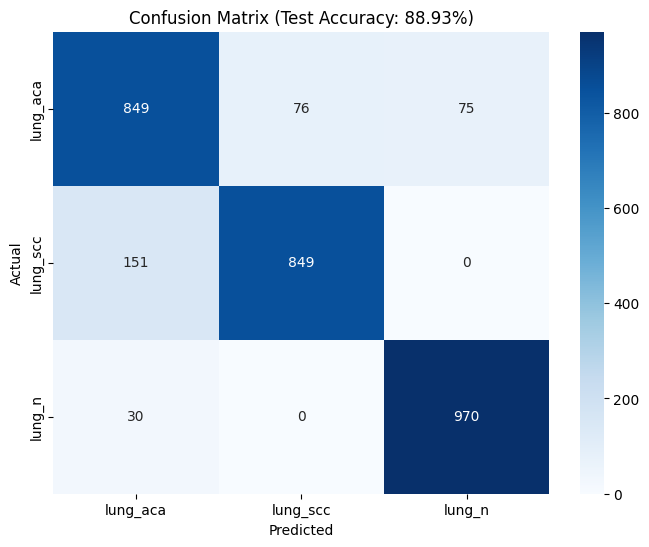

In [63]:
plt.figure(figsize=(8, 6))
plt.title(f"Confusion Matrix (Test Accuracy: {accuracy:.2f}%)")
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=list(label_mapping.keys()),
    yticklabels=list(label_mapping.keys())
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()